In [76]:
import matplotlib.pyplot as plt

"""
In this notebook, we'll go through the steps of training a CRNN (CNN + RNN) model for handwriting recognition. The model will be trained using the CTC (Connectionist Temporal Classification) loss.
"""

"\nIn this notebook, we'll go through the steps of training a CRNN (CNN + RNN) model for handwriting recognition. The model will be trained using the CTC (Connectionist Temporal Classification) loss.\n"

In [77]:
import cv2
import pandas
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from keras import backend
from keras.models import Model
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Reshape
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Lambda
from keras.layers import Activation
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.optimizers import Adam

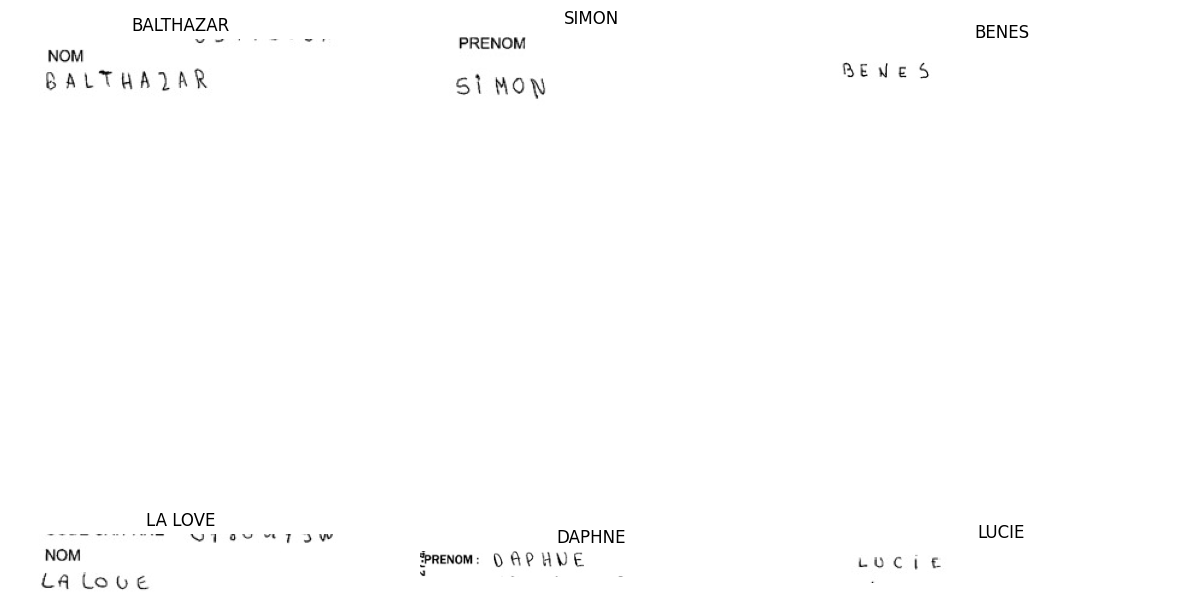

In [78]:
# -------- loading the data for training --------
train = pandas.read_csv("data/written_name_train_v2.csv")
valid = pandas.read_csv("data/written_name_validation_v2.csv")

# -------- plotting data for checking the import --------
plt.figure(figsize=(15, 10))

for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_path = f"data/train_v2/train/{train.loc[i, 'FILENAME']}"
    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    plt.imshow(image, cmap='gray')
    plt.title(train.loc[i, 'IDENTITY'], fontsize=12)
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=0.8)

In [79]:
# -------- cleaning the data --------
print(f"Number of NaNs (Not a Number) in train set: {train['IDENTITY'].isnull().sum()}")
print(f"Number of NaNs (Not a Number) in valid set: {valid['IDENTITY'].isnull().sum()}")

# -------- removing missing data --------
train.dropna(axis=0, inplace=True)
valid.dropna(axis=0, inplace=True)

# -------- removing unreadable data --------
unreadable = train[train['IDENTITY'] == 'UNREADABLE']
unreadable.reset_index(inplace=True, drop = True)

print(f"Number of UNREADABLE values in train set: {len(train[train['IDENTITY'] == 'UNREADABLE'])}")
print(f"Number of UNREADABLE values in valid set: {len(valid[valid['IDENTITY'] == 'UNREADABLE'])}")

train = train[train['IDENTITY'] != 'UNREADABLE']
valid = valid[valid['IDENTITY'] != 'UNREADABLE']

"""
# -------- plotting unreadable data --------
for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_path = f"data/train_v2/train/{unreadable.loc[i, 'FILENAME']}"
    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    plt.imshow(image, cmap='gray')
    plt.title(unreadable.loc[i, 'IDENTITY'], fontsize=12)
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=0.8)
"""

# -------- converting all the labels to uppercase --------
train['IDENTITY'] = train['IDENTITY'].str.upper()
valid['IDENTITY'] = valid['IDENTITY'].str.upper()

# -------- resetting the index --------
train.reset_index(inplace=True, drop=True)
valid.reset_index(inplace=True, drop=True)

Number of NaNs (Not a Number) in train set: 565
Number of NaNs (Not a Number) in valid set: 78
Number of UNREADABLE values in train set: 102
Number of UNREADABLE values in valid set: 12


In [80]:
"""
# -------- preprocessing and preparing the images for training --------

    - the images are loaded as grayscale and reshaped to (256, 64)
    - the width and height are cropped if they are greater than 256 and 64 respectively; if they're smaller
the image is padded with white pixels; finally the image is rotated clockwise to bring the image shape to (x, y)
    - the image is then normalized to range [0, 1]

"""

def preprocessImage(image):
    (height, width) = image.shape[:2]

    output_canvas = np.ones([64, 256]) * 255

    if width > 256:
        image = image[:, :256]
    if height > 64:
        image = image[:64, :]

    output_canvas[:height, :width] = image

    output = cv2.rotate(output_canvas, cv2.ROTATE_90_CLOCKWISE)

    return output


In [98]:
# -------- preparing the training and validation sets --------
training_size = 30000
validation_size = 3000

train_x = []
valid_x = []

for i in range(training_size):
    img_path = f"data/train_v2/train/{train.loc[i, 'FILENAME']}"
    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    image = preprocessImage(image)
    image = image / 255
    train_x.append(image)

for i in range(validation_size):
    img_path = f"data/train_v2/train/{train.loc[i, 'FILENAME']}"
    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    image = preprocessImage(image)
    image = image / 255
    valid_x.append(image)

# -------- reshaping the sets --------
train_x = np.array(train_x).reshape(-1, 256, 64, 1)
valid_x = np.array(valid_x).reshape(-1, 256, 64, 1)


In [92]:
# -------- preparing the labels for CTC loss --------

"""
  A B C D E F G H I J K  L  M  N  O  P  Q  R  S  T  U  V  W  X  Y  Z  -  '
  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28
"""

alphabets = u"ABCDEFGHIJKLMNOPQRSTUVWXYZ-' "
max_str_length = 24
num_of_characters = len(alphabets) + 1
num_of_timestamps = 64

def label2Num(label):
    label_num = []
    for ch in label:
        label_num.append(alphabets.find(ch))

    return np.array(label_num)

def num2Label(num):
    ret = ""
    for ch in num:
        if ch == -1:
            break
        else:
            ret += alphabets[ch]

    return ret

"""
# -------- testing the conversion from labels to nums --------

test_name = "TOMICI-VLAD"
print(test_name)
print(label2Num(test_name))
"""

'\n# -------- testing the conversion from labels to nums --------\n\ntest_name = "TOMICI-VLAD"\nprint(test_name)\nprint(label2Num(test_name))\n'

In [93]:
"""
    - train_y: contains the true labels converted to numbers and padded with -1; the length of each label is max_str_length
    - train_label_len: contains the length of each true label (without padding)
    - train_input_len: contains the length of each predicted label; the length of all the predicted labels is constant
    - train_output: is a dummy output for the ctc loss
"""

train_y = np.ones([training_size, max_str_length]) * -1
train_label_len = np.zeros([training_size, 1])
train_input_len = np.ones([training_size, 1]) * (num_of_timestamps - 2)
train_output = np.zeros([training_size])

for i in range(training_size):
    train_label_len[i] = len(train.loc[i, 'IDENTITY'])
    train_y[i, 0:len(train.loc[i, 'IDENTITY'])] = label2Num(train.loc[i, 'IDENTITY'])



valid_y = np.ones([validation_size, max_str_length]) * -1
valid_label_len = np.zeros([validation_size, 1])
valid_input_len = np.ones([validation_size, 1]) * (num_of_timestamps - 2)
valid_output = np.zeros([validation_size])

for i in range(validation_size):
    valid_label_len[i] = len(valid.loc[i, 'IDENTITY'])
    valid_y[i, 0:len(valid.loc[i, 'IDENTITY'])] = label2Num(valid.loc[i, 'IDENTITY'])

"""
# -------- testing the train_y --------

print(f"True label : {train.loc[100, 'IDENTITY']}")
print(f"train_y : {train_y[100]}")
print(f"train_label_len : {train_label_len[100]}")
print(f"train_input_len : {train_input_len[100]}")
"""

'\n# -------- testing the train_y --------\n\nprint(f"True label : {train.loc[100, \'IDENTITY\']}")\nprint(f"train_y : {train_y[100]}")\nprint(f"train_label_len : {train_label_len[100]}")\nprint(f"train_input_len : {train_input_len[100]}")\n'

In [94]:
# -------- building the model --------

input_data = Input(shape=(256, 64, 1), name="input")

# -------- adding the layers to the model --------
inner = Conv2D(32, (3, 3), padding="same", name="conv1", kernel_initializer="he_normal")(input_data)
inner = BatchNormalization()(inner)
inner = Activation("relu")(inner)
inner = MaxPooling2D(pool_size=(2, 2), name="max1")(inner)

inner = Conv2D(64, (3, 3), padding="same", name="conv2", kernel_initializer="he_normal")(inner)
inner = BatchNormalization()(inner)
inner = Activation("relu")(inner)
inner = MaxPooling2D(pool_size=(2, 2), name="max2")(inner)
inner = Dropout(0.3)(inner)

inner = Conv2D(128, (3, 3), padding="same", name="conv3", kernel_initializer="he_normal")(inner)
inner = BatchNormalization()(inner)
inner = Activation("relu")(inner)
inner = MaxPooling2D(pool_size=(1, 2), name="max3")(inner)
inner = Dropout(0.3)(inner)

# -------- CNN to RNN --------
inner = Reshape(target_shape=((64, 1024)), name="reshape")(inner)
inner = Dense(64, activation="relu", kernel_initializer="he_normal", name="dense1")(inner)

# -------- RNN --------
inner = Bidirectional(LSTM(256, return_sequences=True), name="lstm1")(inner)
inner = Bidirectional(LSTM(256, return_sequences=True), name="lstm2")(inner)

# -------- OUTPUT --------
inner = Dense(num_of_characters, kernel_initializer="he_normal", name="dense2")(inner)
y_pred = Activation("softmax", name="softmax")(inner)

"""

(The output shape of the predictions is (64, 30). The model predicts words of 64 characters and each
character contains the probability of the 30 alphabets which we defined earlier.)

"""

# -------- creating the model --------
model = Model(inputs=input_data, outputs=y_pred)
model.summary()


Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 256, 64, 1)]      0         
                                                                 
 conv1 (Conv2D)              (None, 256, 64, 32)       320       
                                                                 
 batch_normalization_9 (Batc  (None, 256, 64, 32)      128       
 hNormalization)                                                 
                                                                 
 activation_9 (Activation)   (None, 256, 64, 32)       0         
                                                                 
 max1 (MaxPooling2D)         (None, 128, 32, 32)       0         
                                                                 
 conv2 (Conv2D)              (None, 128, 32, 64)       18496     
                                                           

In [95]:
def ctcLambdaFunc(args):
    y_pred, labels, input_length, label_length = args

    y_pred = y_pred[:, 2:, :]

    return backend.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [96]:
labels = Input(name="gtruth_labels", shape=[max_str_length], dtype="float32")
input_length = Input(name="input_length", shape=[1], dtype="int64")
label_length = Input(name="label_length", shape=[1], dtype="int64")

ctc_loss = Lambda(ctcLambdaFunc, output_shape=(1,), name="ctc")([y_pred, labels, input_length, label_length])
final_model = Model(inputs=[input_data, labels, input_length, label_length], outputs=ctc_loss)

In [100]:
# -------- training the model --------
final_model.compile(
    loss={"ctc": lambda y_true, y_pred: y_pred},
    optimizer=Adam(lr=0.0001)
)

print(len(train_x))

final_model.fit(
    x=[train_x, train_y, train_input_len, train_label_len],
    y=train_output,
    validation_data=([valid_x, valid_y, valid_input_len, valid_label_len], valid_output),
    epochs=60,
    batch_size=128
)

30000
Epoch 1/60


2023-12-02 15:00:29.843067: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-12-02 15:00:30.461766: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-12-02 15:00:30.475484: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-12-02 15:00:31.024910: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-12-02 15:00:31.038252: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-12-02 15:00:32.688646: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-12-02 15:00:32.710794: I tensorflow/core/grappler/optimizers/cust

235/235 [==============================] - ETA: 0s - loss: 20.9949

2023-12-02 15:06:22.597363: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-12-02 15:06:22.894914: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-12-02 15:06:22.905818: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-12-02 15:06:23.475409: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-12-02 15:06:23.485066: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


235/235 [==============================] - 386s 2s/step - loss: 20.9949 - val_loss: 22.1271
Epoch 2/60
235/235 [==============================] - 374s 2s/step - loss: 19.8380 - val_loss: 21.5966
Epoch 3/60
235/235 [==============================] - 381s 2s/step - loss: 19.0335 - val_loss: 22.2498
Epoch 4/60
235/235 [==============================] - 408s 2s/step - loss: 17.6454 - val_loss: 24.0893
Epoch 5/60
235/235 [==============================] - 372s 2s/step - loss: 15.4026 - val_loss: 27.3742
Epoch 6/60
235/235 [==============================] - 365s 2s/step - loss: 12.8513 - val_loss: 31.6787
Epoch 7/60
235/235 [==============================] - 363s 2s/step - loss: 10.3513 - val_loss: 35.3592
Epoch 8/60
235/235 [==============================] - 350s 1s/step - loss: 8.1069 - val_loss: 37.4798
Epoch 9/60
235/235 [==============================] - 428s 2s/step - loss: 6.6507 - val_loss: 42.1744
Epoch 10/60
235/235 [==============================] - 422s 2s/step - loss: 5.7520 - v

In [102]:
predictions = model.predict(valid_x)
decoded = backend.get_value(
    backend.ctc_decode(
        predictions,
        input_length=np.ones(predictions.shape[0]) * predictions.shape[1],
        greedy=True)[0][0]
)

prediction = []
for i in range(validation_size):
    prediction.append(num2Label(decoded[i]))

2023-12-03 00:02:00.287223: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-12-03 00:02:00.632688: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-12-03 00:02:00.644354: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-12-03 00:02:01.282613: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-12-03 00:02:01.291706: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


94/94 [==============================] - 9s 69ms/step


In [104]:
y_true = valid.loc[0:validation_size, 'IDENTITY']
correct_char = 0
total_char = 0
correct = 0

for i in range(validation_size):
    pr = prediction[i]
    tr = y_true[i]
    total_char += 1

    for j in range(min(len(tr), len(pr))):
        if tr[j] == pr[j]:
            correct_char += 1

    if pr == tr:
        correct += 1

print(f"Correct characters predicted: {correct_char * 100 / total_char}")
print(f"Correct words predicted: {correct * 100 / validation_size}")

Correct characters predicted: 46.53333333333333
Correct words predicted: 0.03333333333333333


1/1 [==============================] - 0s 51ms/step


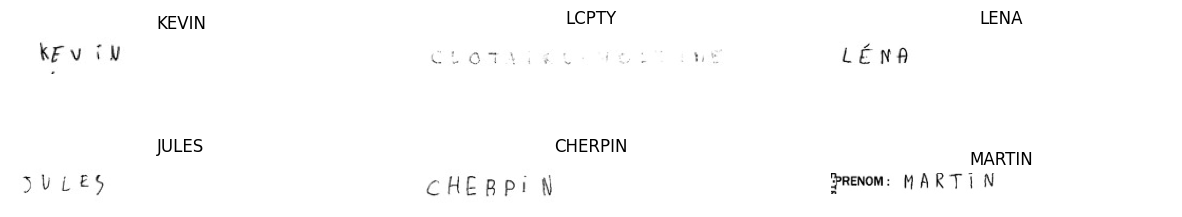

In [109]:
test= pandas.read_csv("data/written_name_test_v2.csv")

plt.figure(figsize=(15, 10))
for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = 'data/test_v2/test/'+test.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap='gray')

    image = preprocessImage(image)
    image = image/255.
    pred = model.predict(image.reshape(1, 256, 64, 1))
    decoded = backend.get_value(backend.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1],
                                       greedy=True)[0][0])
    plt.title(num2Label(decoded[0]), fontsize=12)
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)